# How to Auto Train YOLOv8 Model with Autodistill

Autodistill uses big, slower foundation models to train small, faster supervised models. Using `autodistill`, you can go from unlabeled images to inference on a custom model running at the edge with no human intervention in between.

![Autodistill Steps](https://media.roboflow.com/open-source/autodistill/steps.jpg)

As foundation models get better and better they will increasingly be able to augment or replace humans in the labeling process. We need tools for steering, utilizing, and comparing these models. Additionally, these foundation models are big, expensive, and often gated behind private APIs. For many production use-cases, we need models that can run cheaply and in realtime at the edge.

![Autodistill Connections](https://media.roboflow.com/open-source/autodistill/connections.jpg)



## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Sat Oct 14 19:52:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##  Install autodistill

**NOTE:** Autodistill is an ecosystem for using big, slower foundation models to train small, faster supervised models. Each Base, as well as the Target model, has its own separate repository and pip package.

In [ ]:
!pip install -q \
autodistill \
autodistill-grounded-sam \
autodistill-yolov8 \
roboflow \ #Roboflow is a known service that simplifies the processes of building, training, and deploying computer vision models.
           #It's particularly used for handling datasets, preprocessing, augmenting, and managing data for machine learning.
supervision==0.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.4/82.4 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.0/527.0 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 112.4 MB/

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Image dataset preperation

**NOTE:** To use Autodistill all you need to have is a folder of images that you want to automatically annotate, and use for target model training.

In [ ]:
!mkdir {HOME}/images # create a new folder named "images" in the directory stored in the HOME variable.

### Download raw videos

Note: We will start with a directory containing video files and we will go through how to turn it into a ready-to-use collection of images. If you are working with your images, you can skip this part

In [ ]:
!mkdir {HOME}/videos
%cd {HOME}/videos #This command changes the current working directory of the environment to the "videos" directory

# download zip file containing videos
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt" -O milk.zip && rm -rf /tmp/cookies.txt

# unzip videos
!unzip milk.zip

/content/videos
--2023-10-14 19:52:39--  https://docs.google.com/uc?export=download&confirm=t&id=1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt
Resolving docs.google.com (docs.google.com)... 172.217.194.101, 172.217.194.100, 172.217.194.102, ...
Connecting to docs.google.com (docs.google.com)|172.217.194.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/agk88l17slb0ung8rip4i7qj2lsupfpv/1697313150000/04309230031174164349/*/1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt?e=download&uuid=2b4d3055-8a73-42da-af1d-d23045e3ec42 [following]
--2023-10-14 19:52:40--  https://doc-08-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/agk88l17slb0ung8rip4i7qj2lsupfpv/1697313150000/04309230031174164349/*/1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt?e=download&uuid=2b4d3055-8a73-42da-af1d-d23045e3ec42
Resolving doc-08-ag-docs.googleusercontent.com (doc-08-ag-docs.googleusercontent.com)

### Convert videos into images

**NOTE:** Now, let's convert videos into images. By default, the code below saves every `10th` frame from each video. You can change this by manipulating the value of the `FRAME_STRIDE` parameter.

In [ ]:
VIDEO_DIR_PATH = f"{HOME}/videos"
IMAGE_DIR_PATH = f"{HOME}/images"
FRAME_STRIDE = 10

**NOTE:** Notice that we put two of our videos aside so that we can use them at the end of the notebook to evaluate our model.

In [ ]:
import supervision as sv
from tqdm.notebook import tqdm

video_paths = sv.list_files_with_extensions( #This is presumably a method from the supervision library that lists files in a specified directory (VIDEO_DIR_PATH)
                                            # with specific extensions (in this case, video file formats "mov" and "mp4").
    directory=VIDEO_DIR_PATH,
    extensions=["mov", "mp4"])

TEST_VIDEO_PATHS, TRAIN_VIDEO_PATHS = video_paths[:2], video_paths[2:] #split the dataset

for video_path in tqdm(TRAIN_VIDEO_PATHS):
    video_name = video_path.stem
    image_name_pattern = video_name + "-{:05d}.png"
    with sv.ImageSink(target_dir_path=IMAGE_DIR_PATH, image_name_pattern=image_name_pattern) as sink:
        for image in sv.get_video_frames_generator(source_path=str(video_path), stride=FRAME_STRIDE):
            sink.save_image(image=image)

  0%|          | 0/6 [00:00<?, ?it/s]

### Display image sample

**NOTE:** Before we start building a model with autodistill, let's make sure we have everything we need.

In [ ]:
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 165


**NOTE:** We can also plot sample of our image dataset.

In [ ]:
IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 16 # number of images
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

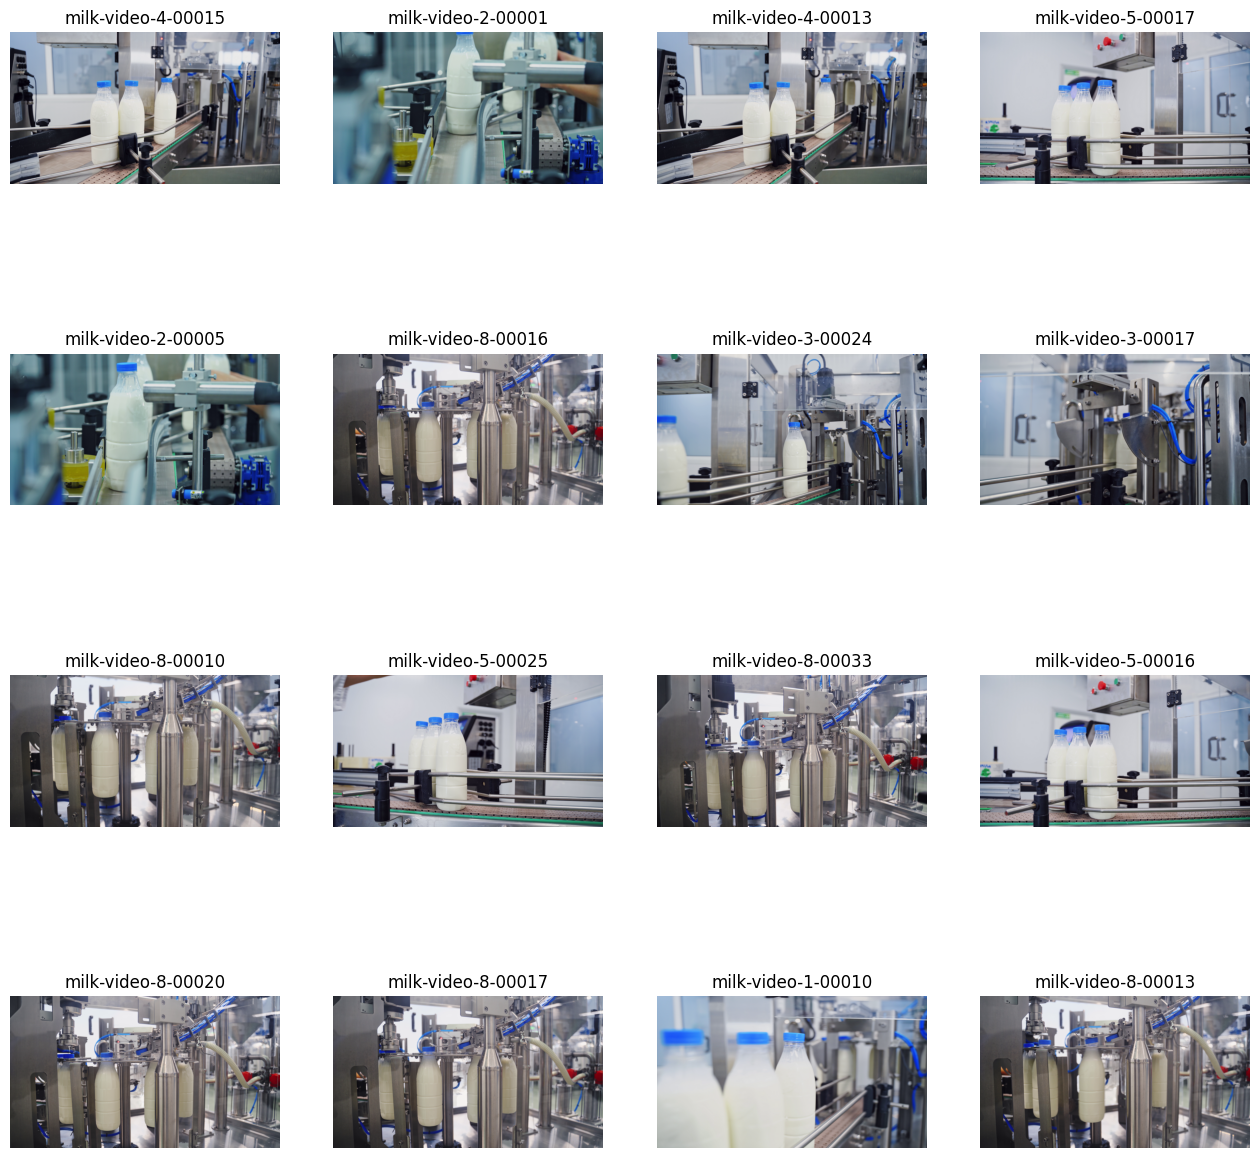

In [ ]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE) #display a collection of images in a grid format.

##  Autolabel dataset

### Define ontology

**Ontology** - an Ontology defines how your Base Model is prompted, what your Dataset will describe, and what your Target Model will predict. A simple Ontology is the CaptionOntology which prompts a Base Model with text captions and maps them to class names. Other Ontologies may, for instance, use a CLIP vector or example images instead of a text caption.

In [ ]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "milk bottle": "bottle", #prompt, label
    "blue cap": "cap"
})


### Initiate base model and autolabel

**Base Model** - A Base Model is a large foundation model that knows a lot about a lot. Base models are often multimodal and can perform many tasks. They're large, slow, and expensive. Examples of Base Models are GroundedSAM and GPT-4's upcoming multimodal variant. We use a Base Model (along with unlabeled input data and an Ontology) to create a Dataset.

In [ ]:
DATASET_DIR_PATH = f"{HOME}/dataset"

**NOTE:** Base Models are slow... Make yourself a coffee, autolabeing may take a while. ☕

In [ ]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology) # base model is initialized by ontology
# this will return a dataset whole label dataset
dataset = base_model.label( #label the dataset
    input_folder=IMAGE_DIR_PATH, #processing images with the "png" extension in "IMAGE_DIR_PATH"
    extension=".png",
    output_folder=DATASET_DIR_PATH) # the path where the labeled dataset will be stored.

trying to load grounding dino directly
downloading dino model weights


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Labeling /content/images/milk-video-4-00015.png:   0%|          | 0/165 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Labeling /content/images/milk-video-2-00008.png: 100%|██████████| 

Labeled dataset created - ready for distillation.


### Display dataset sample

**Dataset** - a Dataset is a set of auto-labeled data that can be used to train a Target Model. It is the output generated by a Base Model.

In [ ]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [ ]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

132

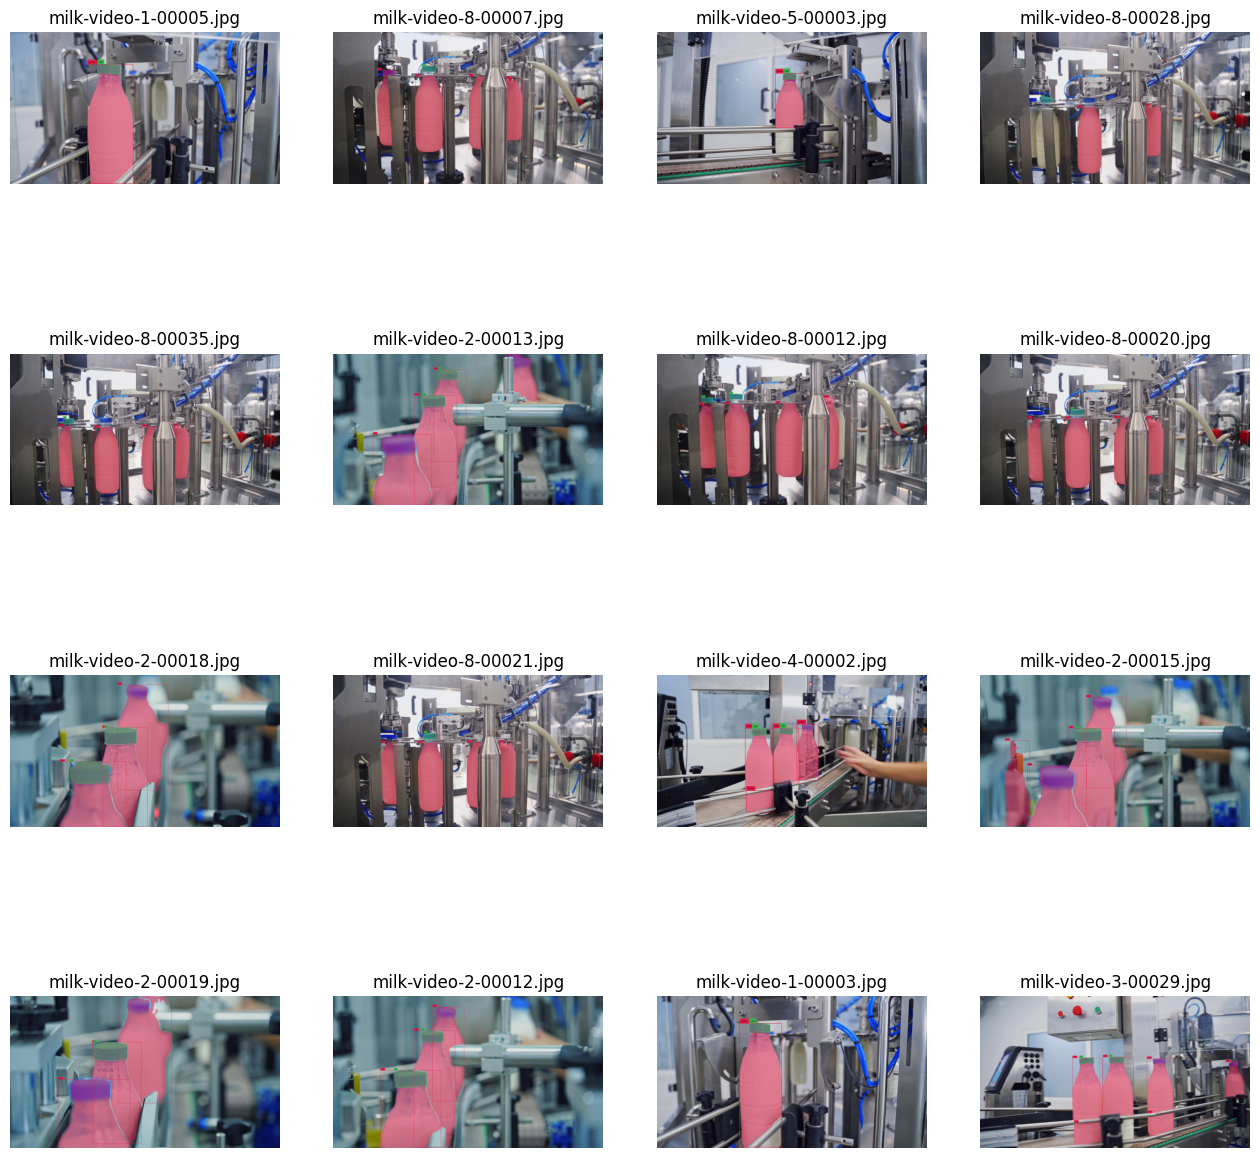

In [ ]:
import supervision as sv

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]#getting a list of image names from the dataset but only takes as many names as specified by SAMPLE_SIZE

# set up two "annotators", drawing masks and drawing boxes, which will mark areas of interest in the image
mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

#Process Each Image
images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

##  Train target model - YOLOv8

**Target Model** - a Target Model is a supervised model that consumes a Dataset and outputs a distilled model that is ready for deployment. Target Models are usually small, fast, and fine-tuned to perform a specific task very well (but they don't generalize well beyond the information described in their Dataset). Examples of Target Models are YOLOv8 and DETR.

In [ ]:
%cd {HOME} #%cd: change directory

from autodistill_yolov8 import YOLOv8

target_model = YOLOv8("yolov8n.pt")
target_model.train(DATA_YAML_PATH, epochs=50) #start training process

/content


100%|██████████| 6.23M/6.23M [00:00<00:00, 293MB/s]
New https://pypi.org/project/ultralytics/8.0.198 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset/data.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visuali

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png      val_batch0_labels.jpg
confusion_matrix.png				    R_curve.png       val_batch0_pred.jpg
events.out.tfevents.1697314415.48d2f6e633cf.3660.0  results.csv       val_batch1_labels.jpg
F1_curve.png					    results.png       val_batch1_pred.jpg
labels_correlogram.jpg				    train_batch0.jpg  weights
labels.jpg					    train_batch1.jpg
P_curve.png					    train_batch2.jpg


## ⚖️ Evaluate target model

**NOTE:** As with the regular YOLOv8 training, we can now take a look at artifacts stored in `runs` directory.

/content


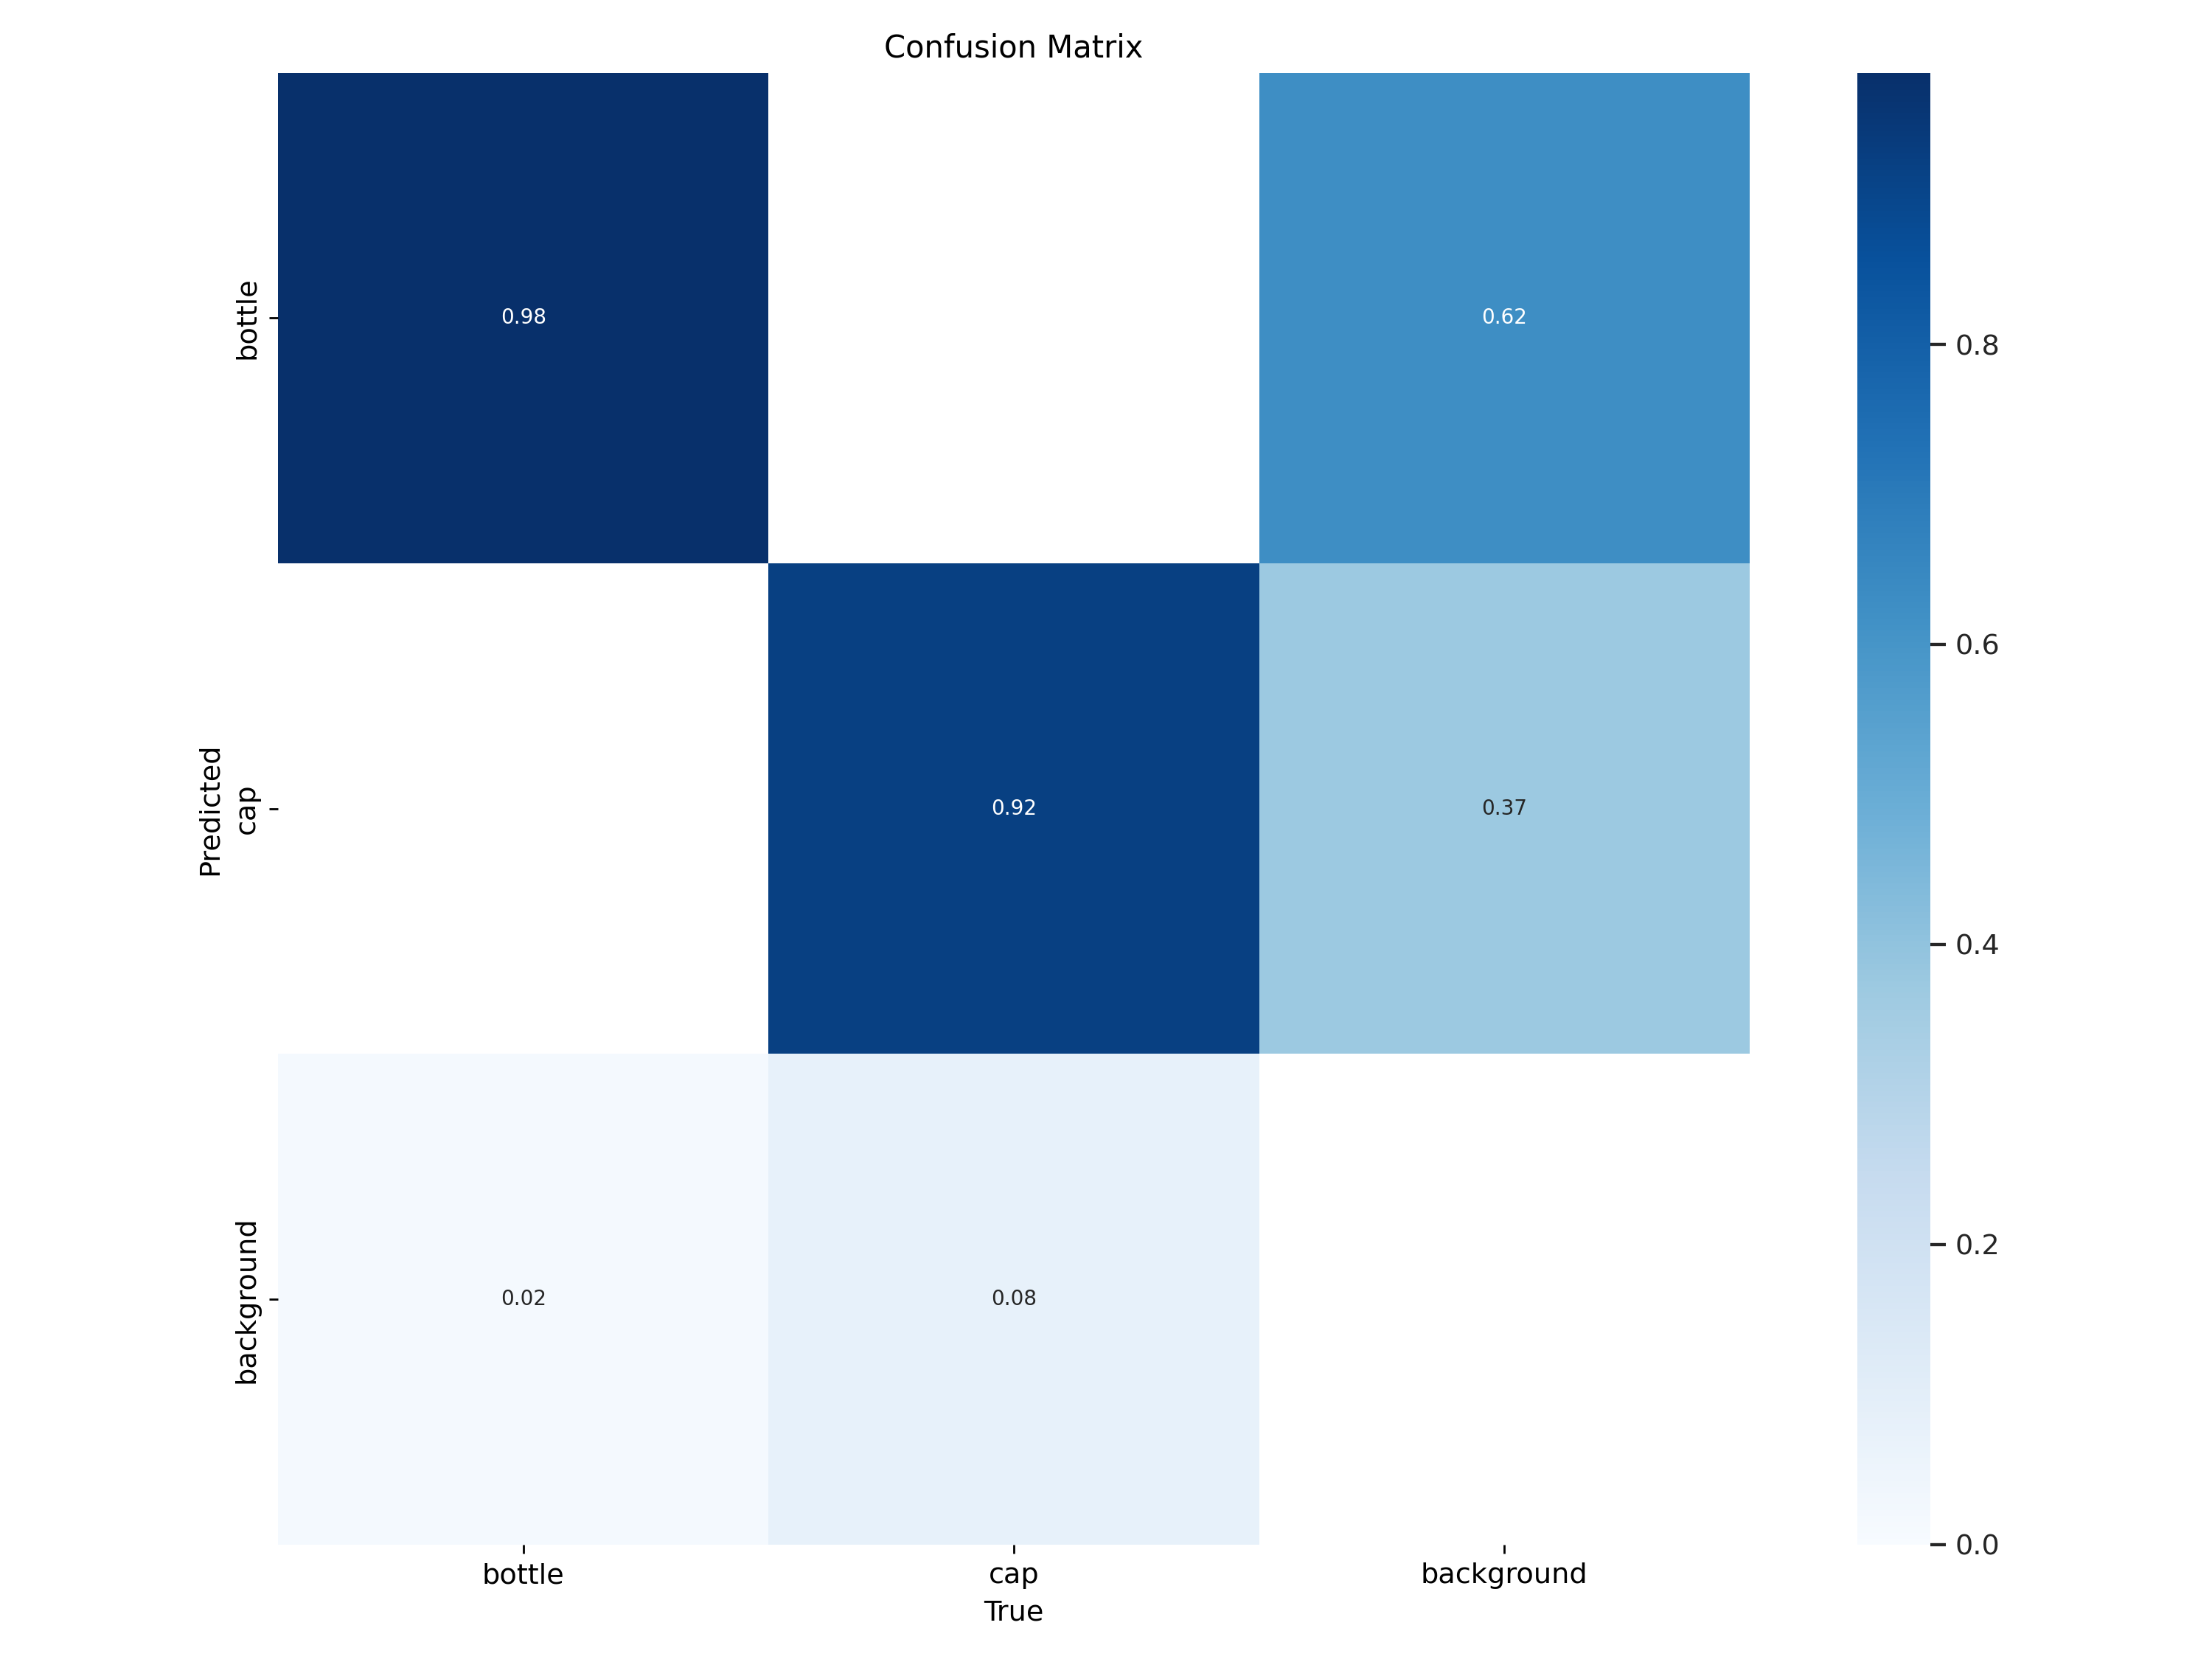

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


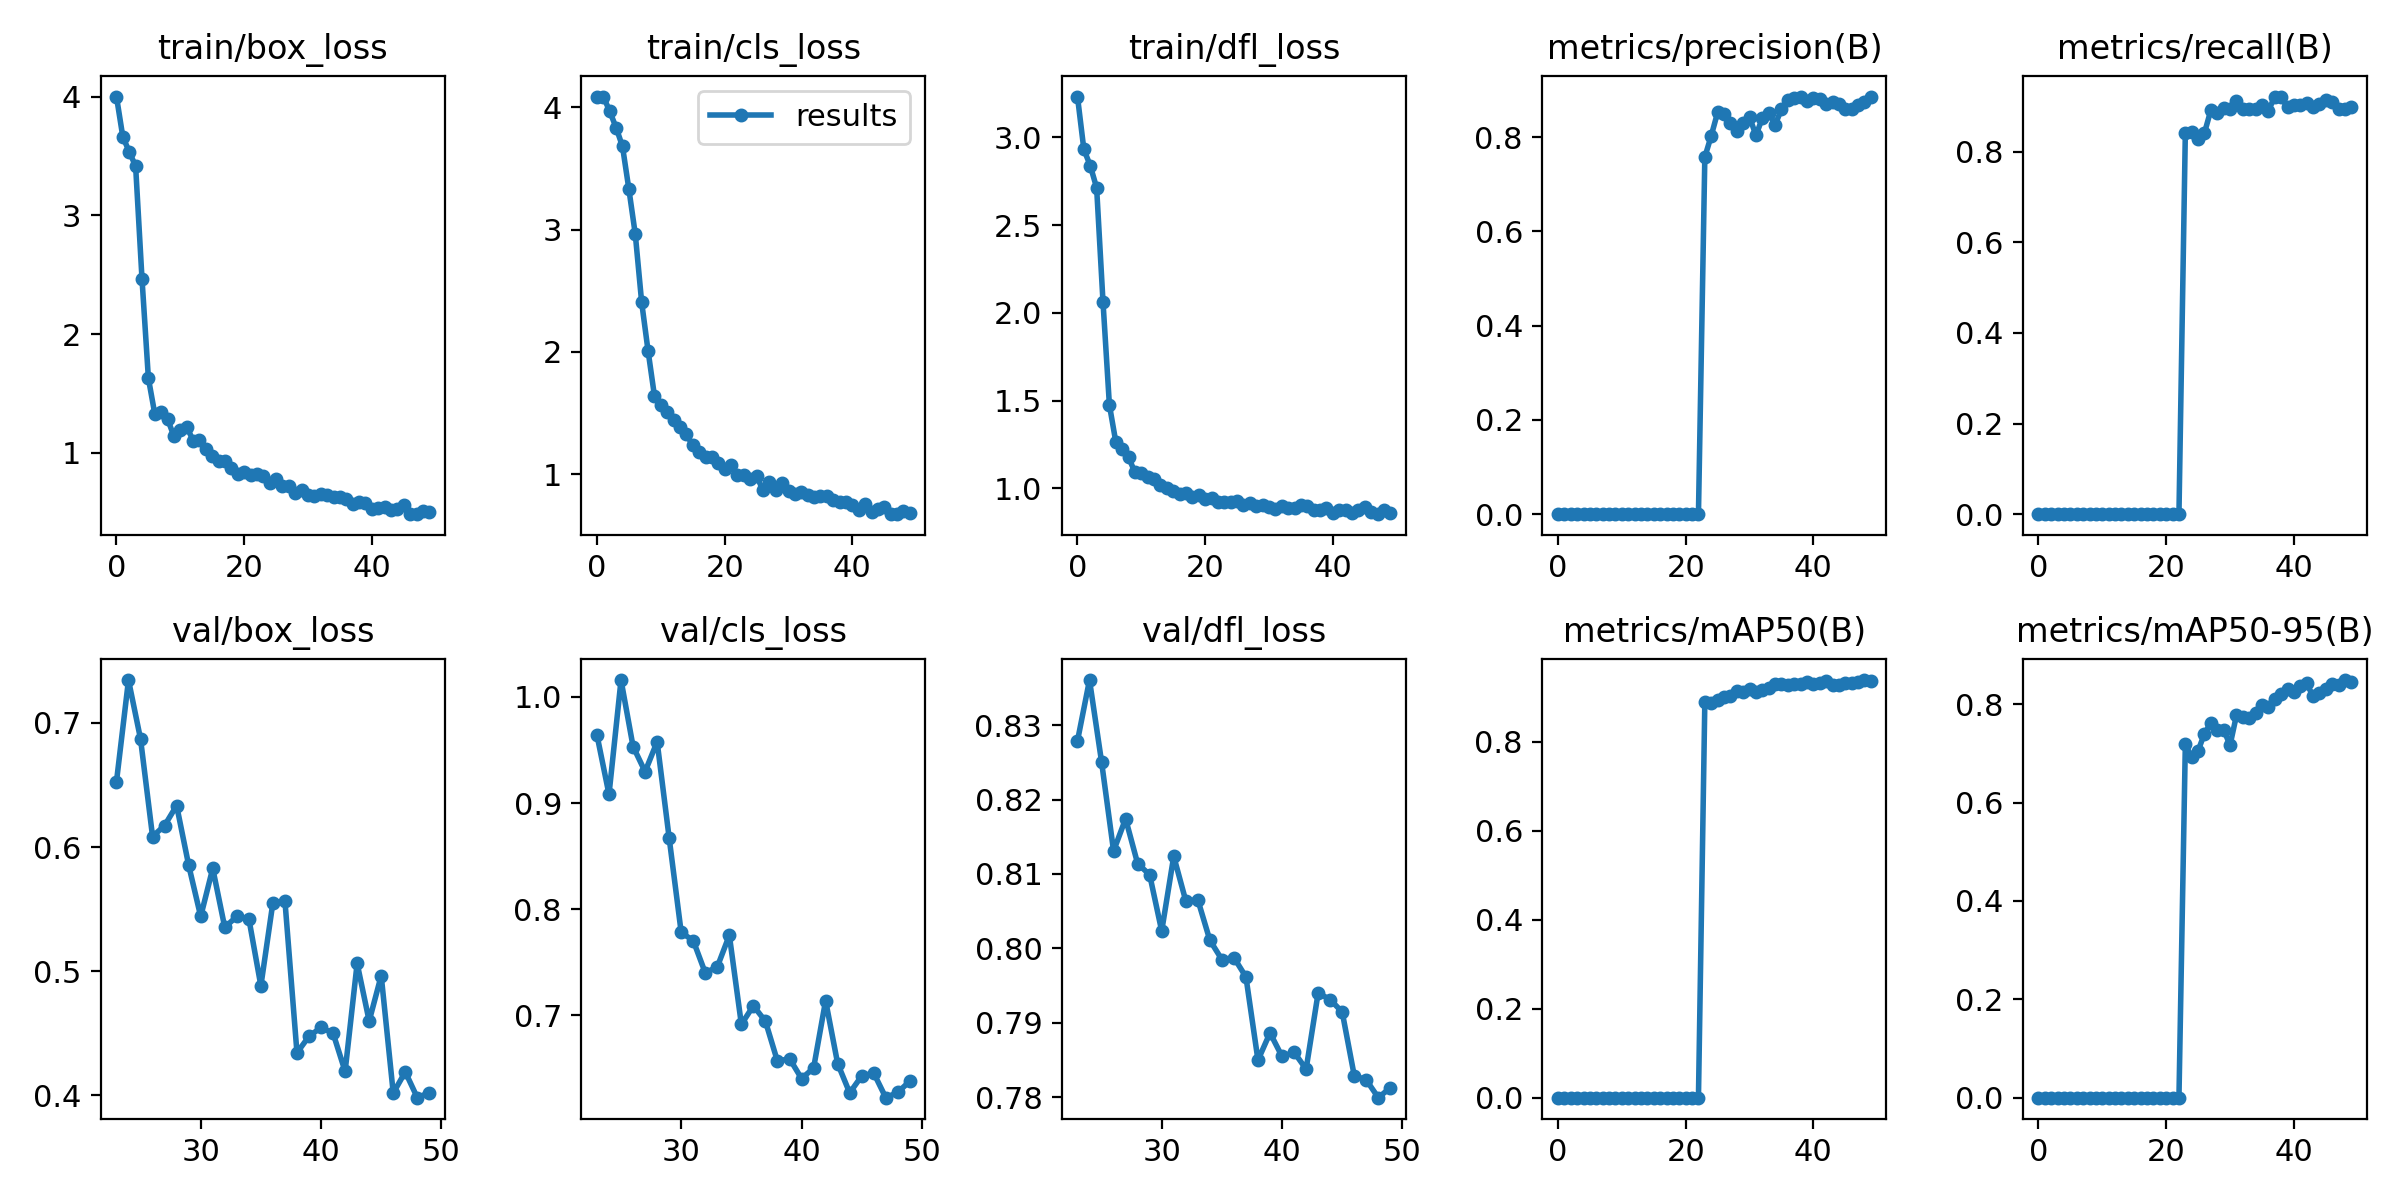

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


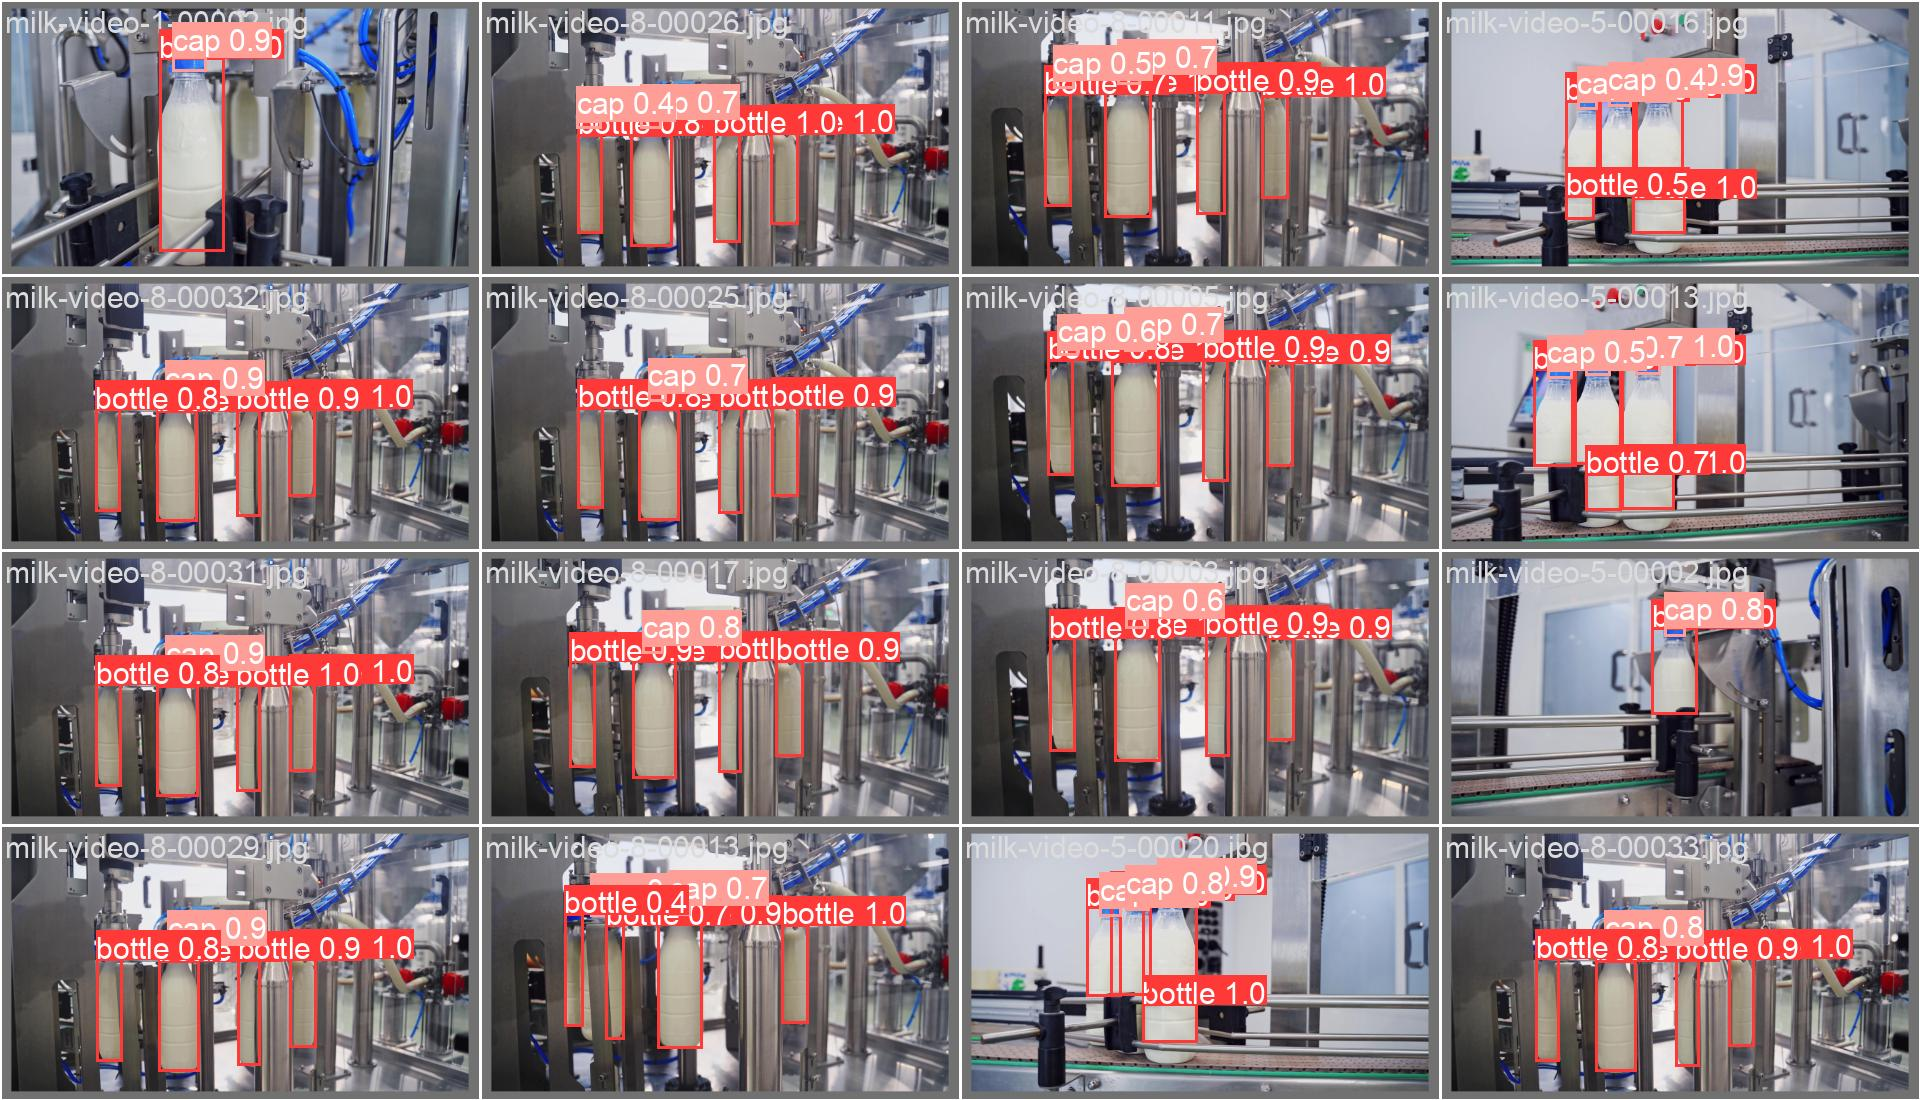

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## 🎬 Run Inference on a video

In [ ]:
INPUT_VIDEO_PATH = TEST_VIDEO_PATHS[0]
OUTPUT_VIDEO_PATH = f"{HOME}/output.mp4"
TRAINED_MODEL_PATH = f"{HOME}/runs/detect/train/weights/best.pt"

In [ ]:
!yolo predict model={TRAINED_MODEL_PATH} source={INPUT_VIDEO_PATH}

Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs

video 1/1 (1/140) /content/videos/milk-video-7.mov: 384x640 4 bottles, 1 cap, 104.1ms
video 1/1 (2/140) /content/videos/milk-video-7.mov: 384x640 4 bottles, 1 cap, 6.6ms
video 1/1 (3/140) /content/videos/milk-video-7.mov: 384x640 4 bottles, 1 cap, 6.2ms
video 1/1 (4/140) /content/videos/milk-video-7.mov: 384x640 5 bottles, 6.3ms
video 1/1 (5/140) /content/videos/milk-video-7.mov: 384x640 4 bottles, 6.4ms
video 1/1 (6/140) /content/videos/milk-video-7.mov: 384x640 4 bottles, 6.2ms
video 1/1 (7/140) /content/videos/milk-video-7.mov: 384x640 4 bottles, 8.5ms
video 1/1 (8/140) /content/videos/milk-video-7.mov: 384x640 4 bottles, 7.0ms
video 1/1 (9/140) /content/videos/milk-video-7.mov: 384x640 4 bottles, 6.1ms
video 1/1 (10/140) /content/videos/milk-video-7.mov: 384x640 4 bottles, 6.1ms
video 1/1 (11/140) /conten